In [ ]:
import numpy as np
import pandas as pd
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from scipy.stats import boxcox, shapiro, probplot
from scipy.cluster.hierarchy import dendrogram, linkage
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 


In [ ]:
df=pd.read_csv("wholesale-customers.csv")

In [ ]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,DetergentsPaper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [ ]:
df.isnull().sum()

Channel            0
Region             0
Fresh              0
Milk               0
Grocery            0
Frozen             0
DetergentsPaper    0
Delicassen         0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Channel          440 non-null    int64
 1   Region           440 non-null    int64
 2   Fresh            440 non-null    int64
 3   Milk             440 non-null    int64
 4   Grocery          440 non-null    int64
 5   Frozen           440 non-null    int64
 6   DetergentsPaper  440 non-null    int64
 7   Delicassen       440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


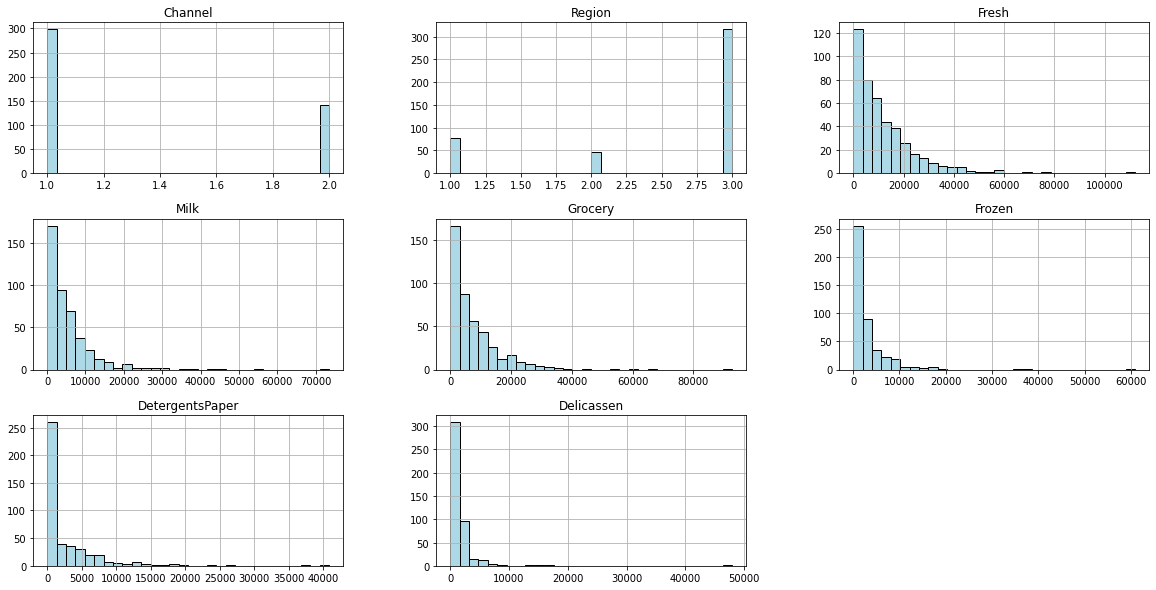

In [ ]:
df.hist(figsize=(20,10),bins=30, color='lightblue', edgecolor='black')
plt.show()

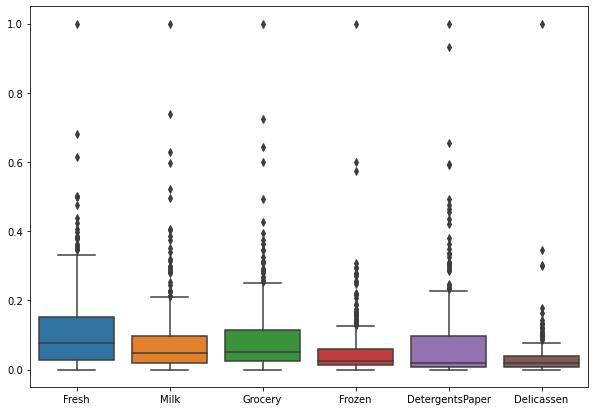

In [ ]:
norm=df.iloc[:,2:] #Numerical data

scaler=MinMaxScaler()
columns=df.columns[2:]
norm=scaler.fit_transform(df.iloc[:,2:]) #Only numeric variables
norm=pd.DataFrame(norm, columns=columns)

plt.figure(figsize=(10,7))
sns.boxplot(data=norm)
plt.show()

In [ ]:
for i in norm.columns:
    iqr=np.percentile(norm[i], 75)-np.percentile(norm[i], 25)
    per75=np.percentile(norm[i], 75)
    per25=np.percentile(norm[i], 25)
    norm[i]=np.where(norm[i]>per75+1.5*iqr, per75+1.5*iqr,norm[i] )
    norm[i]=np.where(norm[i]<per25-1.5*iqr, per25-1.5*iqr,norm[i] )

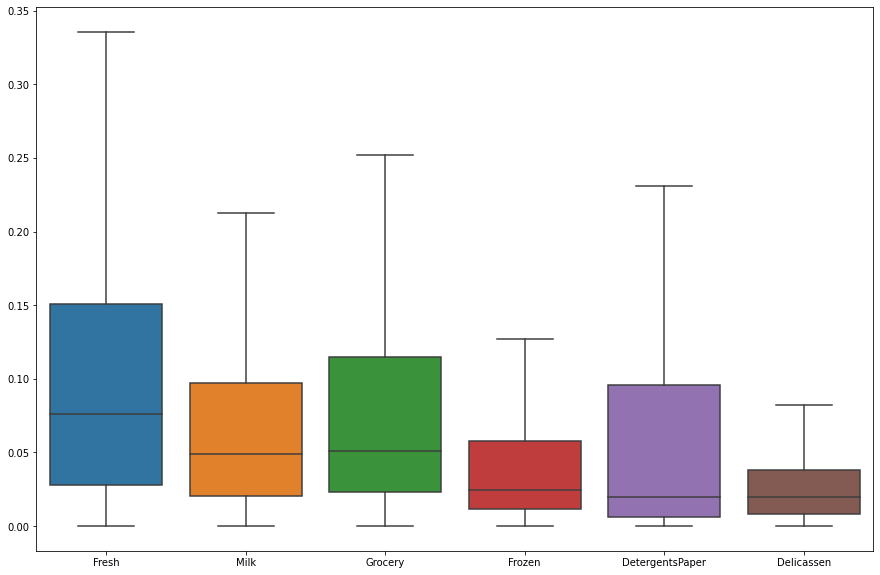

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(data=norm)
plt.show()

In [ ]:
data=pd.get_dummies(data=df, columns= ['Region','Channel'], drop_first=True)

#Uniting our categorical dummified variables with numerical normalized data.

data.iloc[:,:6]=norm

In [ ]:
elbow_results=[]
for i in range(2,10):
    kmeans=KMeans(init='k-means++' , n_clusters=i, random_state=0)
    results=cross_validate(kmeans, data, cv=5)
    elbow_results.append(results['test_score'].mean()*-1)

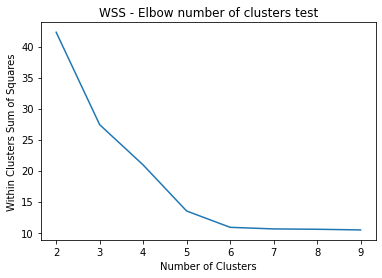

In [ ]:
plt.plot(range(2,len(elbow_results)+2) , elbow_results)
plt.title('WSS - Elbow number of clusters test')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Clusters Sum of Squares')
plt.show()

In [ ]:
kmeans=KMeans(init='k-means++' , n_clusters=3, random_state=0)

cluster_model=kmeans.fit(data)


df['clusters']=cluster_model.predict(data).astype('str')

data['clusters']=df['clusters']

In [ ]:
data['clusters']

0      1
1      1
2      1
3      0
4      1
      ..
435    0
436    0
437    1
438    0
439    0
Name: clusters, Length: 440, dtype: object

In [ ]:
pca=PCA(n_components=len(data.columns)-1)

pca.fit(data.iloc[:,:-1])

pca.explained_variance_ratio_

array([0.44898794, 0.41944214, 0.10125098, 0.01534223, 0.00885386,
       0.00259987, 0.00193943, 0.00092444, 0.00065911])

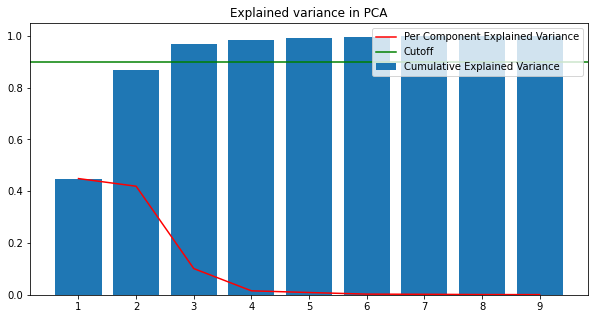

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(range(1,10),pca.explained_variance_ratio_, c='red', label='Per Component Explained Variance')
plt.bar(range(1,10), height=np.cumsum(pca.explained_variance_ratio_), label='Cumulative Explained Variance')
plt.axhline(y=0.9, c='g', label='Cutoff')
plt.title('Explained variance in PCA')
plt.xticks(range(1,10))
plt.legend(loc=1)
plt.show()

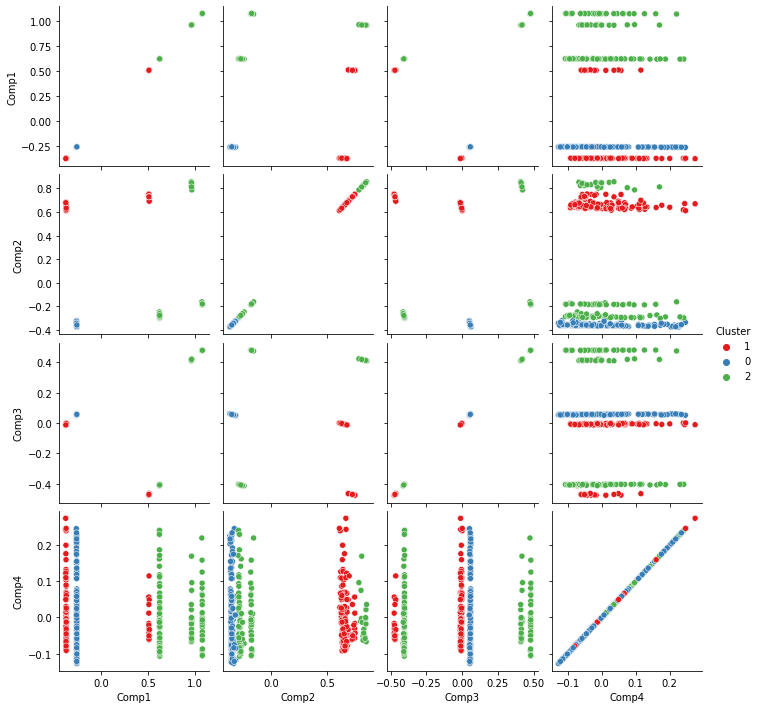

In [ ]:
pca=PCA(n_components=4)
reduced=pca.fit_transform(data.iloc[:,:-1])

reduced=pd.DataFrame(np.column_stack([reduced, data.clusters]), columns=['Comp1','Comp2','Comp3','Comp4','Cluster'])

sns.pairplot(reduced, hue='Cluster', diag_kind=None, vars=reduced.columns[0:-1], palette='Set1')
plt.show()

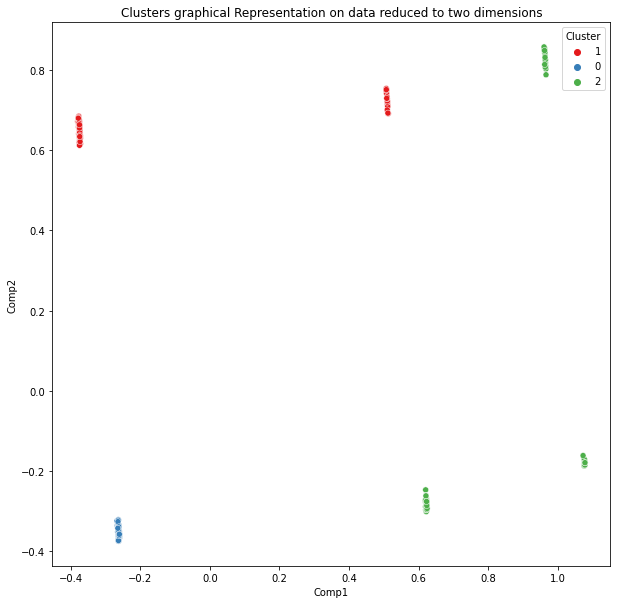

In [ ]:
pca=PCA(n_components=2)
reduced=pca.fit_transform(data.iloc[:,:-1])
reduced=pd.DataFrame(np.column_stack([reduced, df.clusters]), columns=['Comp1','Comp2','Cluster'])

plt.figure(figsize=(10,10))
sns.scatterplot(data=reduced, hue='Cluster', x='Comp1',y='Comp2', palette='Set1')
plt.title('Clusters graphical Representation on data reduced to two dimensions',  fontsize=12)
plt.show()

In [ ]:
o-